
# SCHISM procedural example

In this notebook we will use the SCHOSM grid, config and data objects to define a SCHISM workspace

In [1]:
%load_ext autoreload
%autoreload 2

# turn off warnings
import warnings
warnings.filterwarnings('ignore')

import sys
from datetime import datetime
from pathlib import Path
from rompy.core import DataBlob, TimeRange
from shutil import rmtree

import logging
logging.basicConfig(level=logging.INFO)

HERE = Path('../../tests/schism')


### Workspace basepath

In [2]:
workdir = Path("schism_procedural")
if workdir.exists():
    rmtree(workdir)

workdir.mkdir(exist_ok=True)

### Model Grid

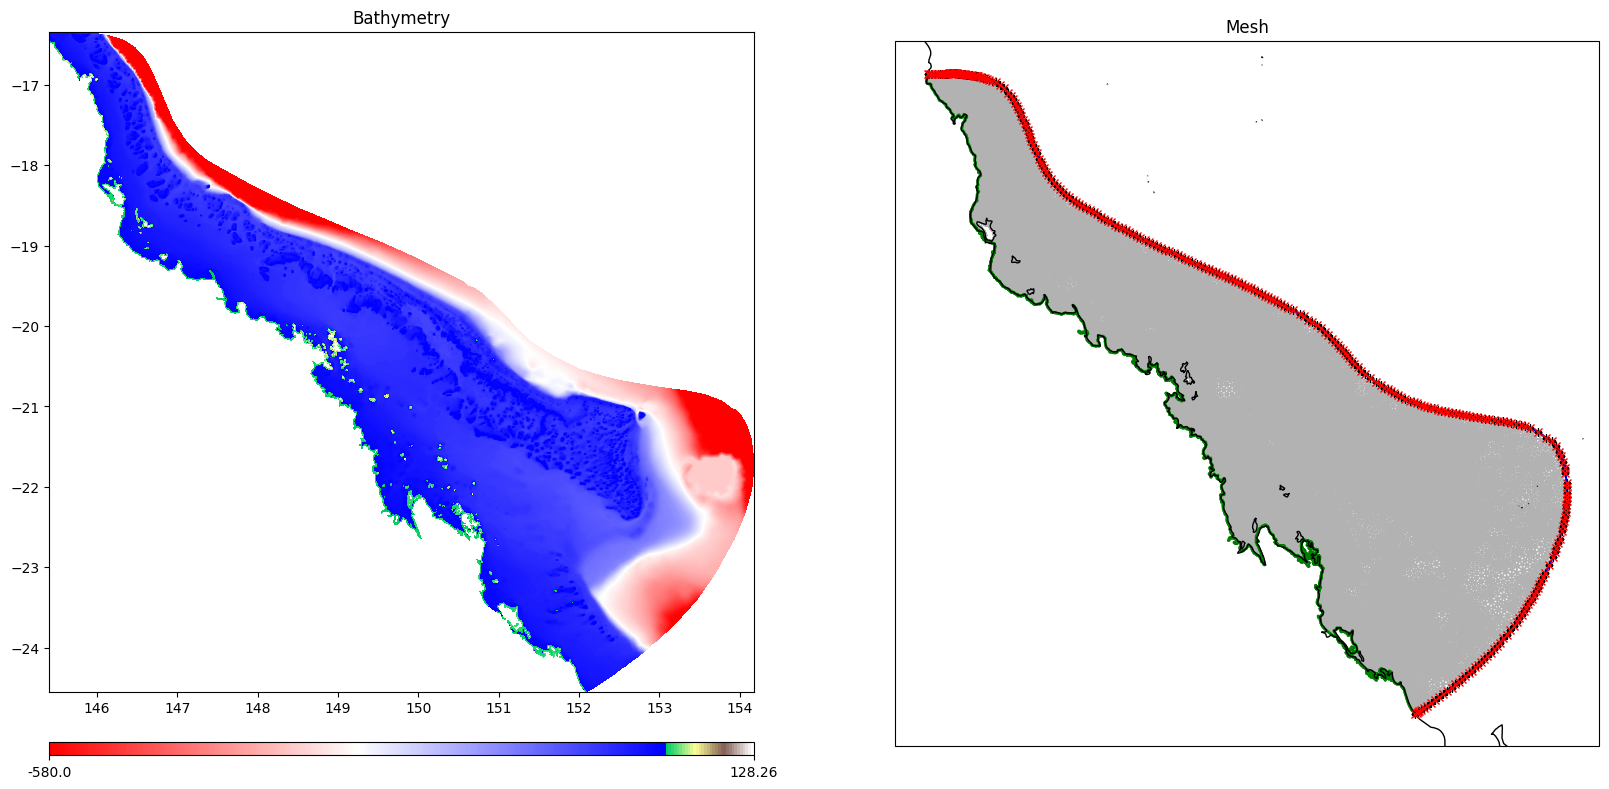

In [3]:
# Grid object

from rompy.schism import Inputs, SCHISMGrid

#SCHISMGrid?

grid=SCHISMGrid(
    hgrid=DataBlob(id="hgrid", source=HERE / "test_data" / "hgrid.gr3"),
    #vgrid=DataBlob(id="vgrid", source=HERE / "test_data" / "vgrid.in"),
    #diffmin=DataBlob(id="diffmin", source=HERE / "test_data" / "diffmin.gr3"),
    #diffmax=DataBlob(id="diffmax", source=HERE / "test_data" / "diffmax.gr3"),
    #manning=DataBlob(id="manning", source=HERE / "test_data" / "manning.gr3"),
    #hgrid_WWM=DataBlob(id="hgrid_WWM", source=HERE / "test_data" / "hgrid_WWM.gr3"),
    wwmbnd=DataBlob(id="wwmbnd", source=HERE / "test_data" / "wwmbnd.gr3"),
)

grid.plot_hgrid()

In [4]:
grid.get(workdir)
list(workdir.glob('*'))

INFO:rompy.schism.grid:Generated diffmin with constant value of 1e-06
INFO:rompy.schism.grid:Generated diffmax with constant value of 1.0
INFO:rompy.schism.grid:Creating symbolic link for hgrid.ll
INFO:rompy.schism.grid:Generated albedo with constant value of 0.15
INFO:rompy.schism.grid:Generated watertype with constant value of 1.0
INFO:rompy.schism.grid:Generated windrot_geo2proj with constant value of 0.0


[PosixPath('schism_procedural/hgrid.gr3'),
 PosixPath('schism_procedural/hgrid.ll'),
 PosixPath('schism_procedural/diffmin.gr3'),
 PosixPath('schism_procedural/watertype.gr3'),
 PosixPath('schism_procedural/albedo.gr3'),
 PosixPath('schism_procedural/windrot_geo2proj.gr3'),
 PosixPath('schism_procedural/wwmbnd.gr3'),
 PosixPath('schism_procedural/tvprop.in'),
 PosixPath('schism_procedural/diffmax.gr3')]


### Work with existing data

This example just uses the existing swan spectral dataset. Data is currently incompletes, this is just an illustration at this point.  
This exercise assumes any processing to the raw forcing data is done with tools outside rompy to handle interpolation or any other required data manipulation.

In [5]:
# First lists import the main data classes
from rompy.schism.data import SCHISMDataSflux, SCHISMDataOcean, SCHISMDataWave, SCHISMDataTides

# Sets also import a few of the minor classes that are used in the construction of these main classes for use in this demo
from rompy.schism.data import SfluxSource, TidalDataset, SfluxAir, SCHISMDataBoundary

# And also lets import some of the core data source objects. These are data input abstractions that work in exactly the same way as 
# with the swan classes, and can be used interchangeably in each of the data classes depending on the data source. We will use a 
# bit of a mix here for illustration purposes.
from rompy.core.data import DataBlob, SourceFile, SourceDataset, SourceIntake, SourceDatamesh
from rompy.core.boundary import SourceWavespectra

### Sflux Data

In [6]:
from rompy.schism.namelists import Sflux_Inputs
# SCHISMDataSflux??
#SfluxSource??
Sflux_Inputs??



Init signature:
Sflux_Inputs(
    *,
    air_1_relative_weight: float = 1.0,
    air_2_relative_weight: float = 99.0,
    air_1_max_window_hours: float = 120.0,
    air_2_max_window_hours: float = 120.0,
    air_1_fail_if_missing: bool = True,
    air_2_fail_if_missing: bool = False,
    air_1_file: str = 'sflux_air_1',
    air_2_file: str = 'sflux_air_2',
    uwind_name: str = 'uwind',
    vwind_name: str = 'vwind',
    prmsl_name: str = 'prmsl',
    stmp_name: str = 'stmp',
    spfh_name: str = 'spfh',
    rad_1_relative_weight: float = 1.0,
    rad_2_relative_weight: float = 99.0,
    rad_1_max_window_hours: float = 24.0,
    rad_2_max_window_hours: float = 24.0,
    rad_1_fail_if_missing: bool = False,
    rad_2_fail_if_missing: bool = False,
    rad_1_file: str = 'sflux_rad_1',
    rad_2_file: str = 'sflux_rad_2',
    dlwrf_name: str = 'dlwrf',
    dswrf_name: str = 'dswrf',
    prc_1_relative_weight: float = 1.0,
    prc_2_relative_weight: float = 99.0,
    prc_1_max_window_hours

In [7]:
# Lets have a look at an flux object. Here we will use a ERA5 dataset exposed through the intake catalog in the tests/data folder.
from rompy.core.time import TimeRange

data = SCHISMDataSflux(
    air_1=SfluxAir(
        id="air_1",
        source=SourceIntake(
            dataset_id="era5",
            catalog_uri=HERE / ".." / "data" / "catalog.yaml",
        ),
        filter={
            "sort": {"coords": ["latitude"]},
        },
    )
)
data.get(destdir=workdir, grid=grid, time=TimeRange(start="2023-01-01", end="2023-01-02", dt=3600))

In [8]:
list(workdir.glob('**/*'))



[PosixPath('schism_procedural/hgrid.gr3'),
 PosixPath('schism_procedural/hgrid.ll'),
 PosixPath('schism_procedural/diffmin.gr3'),
 PosixPath('schism_procedural/sflux_air_1.0001.nc'),
 PosixPath('schism_procedural/watertype.gr3'),
 PosixPath('schism_procedural/albedo.gr3'),
 PosixPath('schism_procedural/sflux'),
 PosixPath('schism_procedural/windrot_geo2proj.gr3'),
 PosixPath('schism_procedural/wwmbnd.gr3'),
 PosixPath('schism_procedural/tvprop.in'),
 PosixPath('schism_procedural/diffmax.gr3'),
 PosixPath('schism_procedural/sflux/sflux_inputs.txt')]

In [9]:
print(output)

NameError: name 'output' is not defined

<xarray.Dataset>
Dimensions:    (latitude: 1, longitude: 1, time: 5)
Coordinates:
  * latitude   (latitude) float32 -20.0
  * longitude  (longitude) float32 150.0
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-01-02
Data variables:
    u10        (time, latitude, longitude) float64 ...
    v10        (time, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-10 00:03:38 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

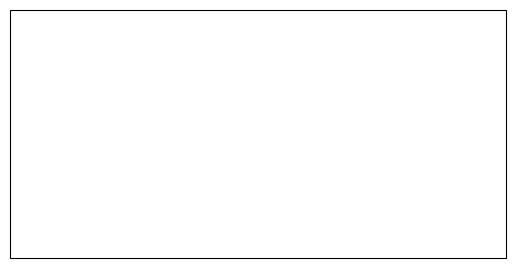

In [21]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import numpy as np

# Create a map
ax = plt.axes(projection=ccrs.PlateCarree())
# load the data
ds = xr.open_dataset("schism_procedural/sflux_air_1.0001.nc")
# wind_speed = np.sqrt(ds.u10**2 + ds.v10**2)
# # plot the data
# wind_speed.isel(time=2).plot(ax=ax, transform=ccrs.PlateCarree())
ds


### Ocean Boundary

In [ ]:
SCHISMDataOcean??

Init signature:
SCHISMDataOcean(
    *,
    elev2D: Optional[rompy.schism.data.SCHISMDataBoundary] = None,
    uv3D: Optional[rompy.schism.data.SCHISMDataBoundary] = None,
    TEM_3D: Optional[rompy.schism.data.SCHISMDataBoundary] = None,
    SAL_3D: Optional[rompy.schism.data.SCHISMDataBoundary] = None,
) -> None
Docstring:     
Usage docs: https://docs.pydantic.dev/2.4/concepts/models/

A base class for creating Pydantic models.

Attributes:
    __class_vars__: The names of classvars defined on the model.
    __private_attributes__: Metadata about the private attributes of the model.
    __signature__: The signature for instantiating the model.

    __pydantic_complete__: Whether model building is completed, or if there are still undefined fields.
    __pydantic_core_schema__: The pydantic-core schema used to build the SchemaValidator and SchemaSerializer.
    __pydantic_custom_init__: Whether the model has a custom `__init__` function.
    __pydantic_decorators__: Metadata containin

In [ ]:

oceandata = SCHISMDataOcean(
                elev2D = SCHISMDataBoundary(
                    id="hycom",
                    source=SourceFile(
                        uri=HERE / "test_data" / "hycom.nc",
                    ),
                    variable="surf_el",
                    coords={"t": "time", "y": "ylat", "x": "xlon", "z": "depth"},
                    )
                )



In [ ]:

oceandata.get(destdir=workdir, grid=grid)
list(workdir.glob("*"))



[PosixPath('schism_procedural/hgrid.gr3'),
 PosixPath('schism_procedural/hgrid.ll'),
 PosixPath('schism_procedural/diffmin.gr3'),
 PosixPath('schism_procedural/sflux_air_1.0001.nc'),
 PosixPath('schism_procedural/watertype.gr3'),
 PosixPath('schism_procedural/albedo.gr3'),
 PosixPath('schism_procedural/sflux'),
 PosixPath('schism_procedural/windrot_geo2proj.gr3'),
 PosixPath('schism_procedural/wwmbnd.gr3'),
 PosixPath('schism_procedural/tvprop.in'),
 PosixPath('schism_procedural/diffmax.gr3'),
 PosixPath('schism_procedural/elev2D.th.nc')]

In [ ]:
ds = xr.open_dataset('schism_procedural/elev2D.th.nc')
ds

<xarray.Dataset>
Dimensions:        (one: 1, time: 3, nOpenBndNodes: 286, nLevels: 1,
                    nComponents: 1)
Coordinates:
  * time           (time) float64 0.0 8.64e+04 1.728e+05
  * nOpenBndNodes  (nOpenBndNodes) int64 0 1 2 3 4 5 ... 280 281 282 283 284 285
  * nComponents    (nComponents) int64 1
  * one            (one) int64 1
Dimensions without coordinates: nLevels
Data variables:
    time_step      (one) float64 ...
    time_series    (time, nOpenBndNodes, nLevels, nComponents) float32 ...

### Wave

In [10]:
SCHISMDataWave??

Init signature:
SCHISMDataWave(
    *,
    model_type: Literal['data_grid'] = 'data_grid',
    id: str,
    source: Union[rompy.core.data.SourceDataset, rompy.core.data.SourceFile, rompy.core.data.SourceIntake, rompy.core.data.SourceDatamesh, rompy.core.boundary.SourceWavespectra],
    filter: Optional[rompy.core.filters.Filter] = None,
    variables: Optional[list[str]] = [],
    coords: Optional[rompy.core.types.DatasetCoords] = DatasetCoords(t='time', x='longitude', y='latitude', z='depth'),
    crop_data: bool = True,
    buffer: float = 0.0,
    spacing: Optional[float] = None,
    sel_method: Literal['idw', 'nearest'] = 'idw',
    sel_method_kwargs: dict = {},
    interpolate_method: Literal['nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'polynomial'] = None,
    interp_method_kwargs: dict = {},
) -> None
Source:        
class SCHISMDataWave(BoundaryWaveStation):
    """This class is used to write SCHISM data from a dataset."""

    def get(
        self,
        destdir: st

In [11]:
wavedata = SCHISMDataWave(
        id="wavedata",
        source=SourceIntake(
            dataset_id="ausspec",
            catalog_uri=HERE / ".." / "data" / "catalog.yaml",
        ),
        coords={'x': "lon", 'y': "lat"},
)


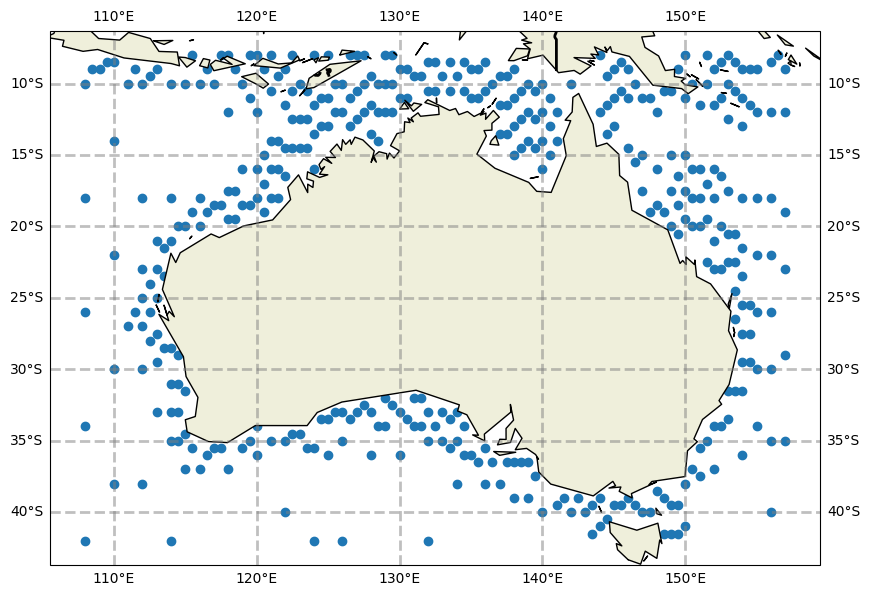

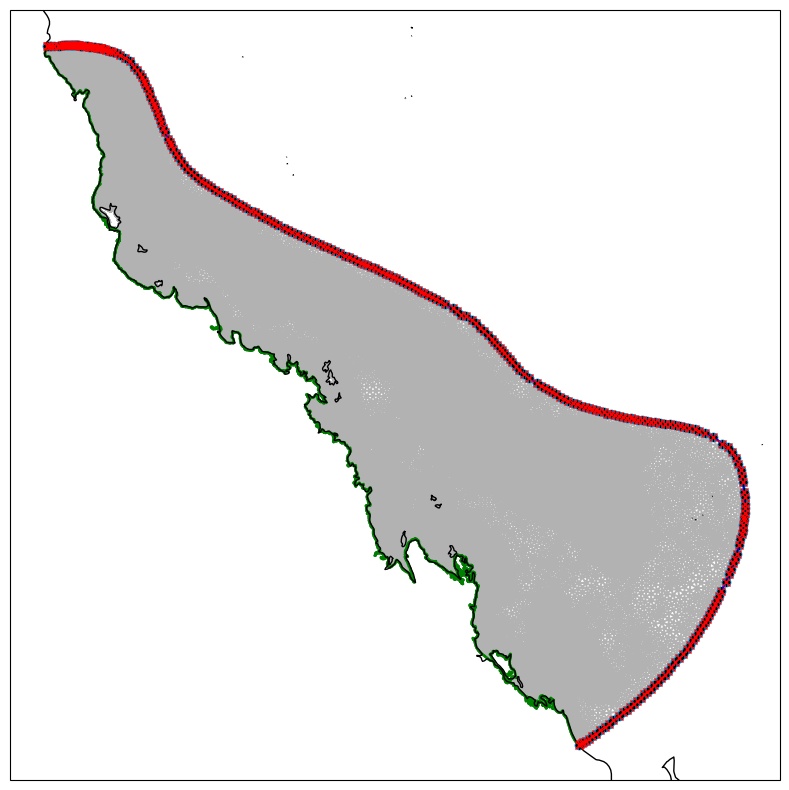

In [12]:
ax = wavedata.plot(model_grid=grid)
wavedata.plot_boundary(ax=ax, grid=grid)

In [15]:
bnd = wavedata.get(destdir=workdir, grid=grid)

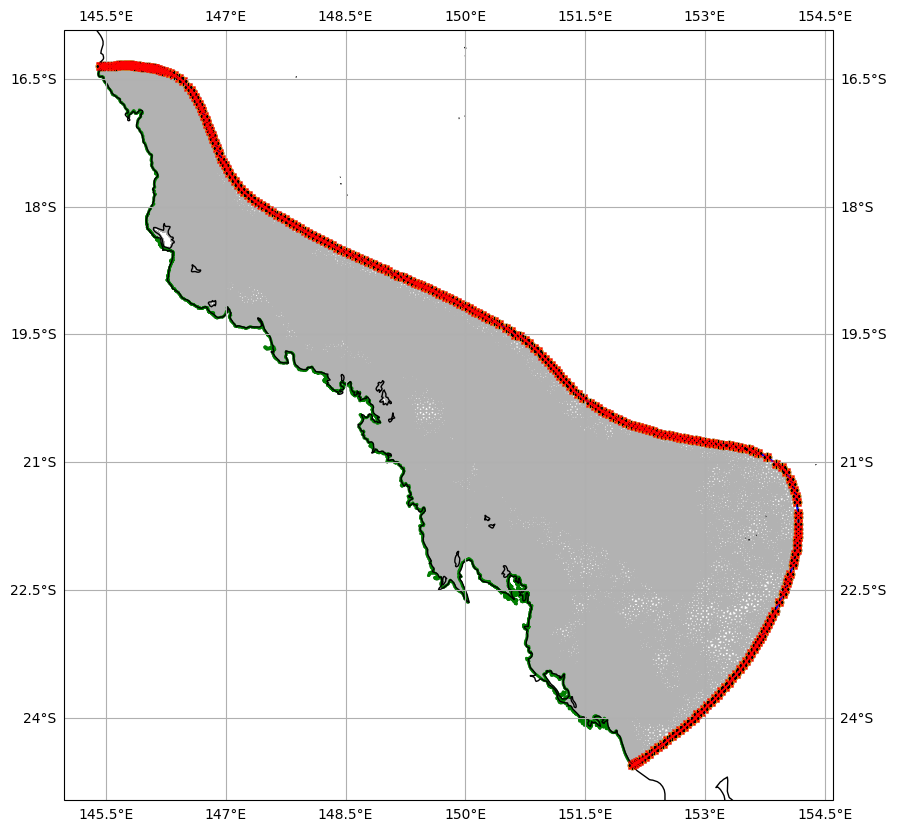

In [28]:
ax = wavedata.plot_boundary(grid=grid)
ax.gridlines(draw_labels=True)
ds = xr.open_dataset(bnd)
ax.scatter(ds.longitude.isel(time=0), ds.latitude.isel(time=0), transform=ccrs.PlateCarree())

In [30]:
ds.longitude.values

array([[152.091545, 152.111797, 152.129784, ..., 145.463464, 145.438752,
        145.427489],
       [152.091545, 152.111797, 152.129784, ..., 145.463464, 145.438752,
        145.427489],
       [152.091545, 152.111797, 152.129784, ..., 145.463464, 145.438752,
        145.427489],
       [152.091545, 152.111797, 152.129784, ..., 145.463464, 145.438752,
        145.427489],
       [152.091545, 152.111797, 152.129784, ..., 145.463464, 145.438752,
        145.427489]])

In [18]:
import xarray as xr
ds = xr.open_dataset(bnd)
ax


### Tidal data

In [36]:
SCHISMDataTides?
TidalDataset?

Init signature:
TidalDataset(
    *,
    elevations: cloudpathlib.anypath.AnyPath,
    velocities: cloudpathlib.anypath.AnyPath,
) -> None
Docstring:     
Usage docs: https://docs.pydantic.dev/2.4/concepts/models/

A base class for creating Pydantic models.

Attributes:
    __class_vars__: The names of classvars defined on the model.
    __private_attributes__: Metadata about the private attributes of the model.
    __signature__: The signature for instantiating the model.

    __pydantic_complete__: Whether model building is completed, or if there are still undefined fields.
    __pydantic_core_schema__: The pydantic-core schema used to build the SchemaValidator and SchemaSerializer.
    __pydantic_custom_init__: Whether the model has a custom `__init__` function.
    __pydantic_decorators__: Metadata containing the decorators defined on the model.
        This replaces `Model.__validators__` and `Model.__root_validators__` from Pydantic V1.
    __pydantic_generic_metadata__: Metadata

In [40]:
tidal_data=TidalDataset(
    elevations=HERE / "test_data"/ "tides"/ "h_m2s2n2k2k1o1p1q1mmmfm4mn4ms42n2s12q1j1l2m3mu2nu2oo1.nc",
    velocities=HERE / "test_data"/ "tides"/ "u_m2s2n2k2k1o1p1q1mmmfm4mn4ms42n2s12q1j1l2m3mu2nu2oo1.nc",
)
# tides = SCHISMDataTides(
#     tidal_data=TidalDataset(
#         elevations=HERE / "test_data"/ "tides"/ "h_m2s2n2k2k1o1p1q1mmmfm4mn4ms42n2s12q1j1l2m3mu2nu2oo1.nc",
#         velocities=HERE / "test_data"/ "tides"/ "u_m2s2n2k2k1o1p1q1mmmfm4mn4ms42n2s12q1j1l2m3mu2nu2oo1.nc",
#     )
# )
# tides.get(
#     destdir=tmp_path,
#     grid=grid2d,
#     time=TimeRange(start="2023-01-01", end="2023-01-02", dt=3600),
# )


ValidationError: 1 validation error for SCHISMDataTides
tidal_data
  Input should be a valid dictionary or instance of TidalDataset [type=model_type, input_value=TidalDataset(elevations=P...2q1j1l2m3mu2nu2oo1.nc')), input_type=TidalDataset]
    For further information visit https://errors.pydantic.dev/2.4/v/model_type

In [ ]:
from rompy.schism import SchismCSIROConfig

config=SchismCSIROConfig(
    grid=grid,
    inputs=Inputs(
        filewave=DataBlob(id="filewave", source=here / "test_data" / "schism_bnd_spec_SWAN_500m_use_in_schism_2021Aug-Nov.nc",
        ),
    ),
)


NameError: name 'here' is not defined

In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(ds.)

### Instantiate config

Note  that most fields are optional, this eample using defaults values.


### Generate workspace


In [ ]:
from rompy.model import ModelRun

run = ModelRun(
    run_id="test_schism",
    period=TimeRange(start=datetime(2021, 8, 1, 0), end=datetime(2021, 11, 29, 0), interval="15M"),
    output_dir=str(workdir),
    config=config
)

rundir = run()


### Check the workspace

In [ ]:
list(Path(rundir).glob("*"))

[PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/hgrid.gr3'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/datasets'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/README'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/schismv59_petrichor_VH_multinode.sh'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/wwminput.nml'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/diffmin.gr3'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/vgrid.in'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/sflux'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/windrot_geo2proj.gr3'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/outputs'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/wwmbnd.gr3'),
 PosixPath('/source/ro